# Project 2 - Grammars

In [1]:
import fuzzingbook_utils

In [2]:
!pip install coverage gcovr

    100% |████████████████████████████████| 215kB 15.5MB/s ta 0:00:01


## Introduction

Testing regular expression (regex) parsers is a challenging task. A simple regex, such as `a?(b|c)+d*`, requires dozens of inputs to cover all possibilities.

To test regex, we use the python [regex](https://pypi.org/project/regex/) module (provided in the `data/regex` directory of this project). We use the source code of the `regex` module so that we can compute the coverage of the module.  

In [3]:
from data.regex.regex_3 import _regex_core
from data.regex.regex_3 import regex

In [4]:
pattern = 'a?(b|c)+d*$'
print('a matches %s: %s' % (pattern, regex.match(pattern, 'a') != None))
print('b matches %s: %s' % (pattern, regex.match(pattern, 'ab') != None))

a matches a?(b|c)+d*$: False
b matches a?(b|c)+d*$: True


An efficient approach to test regex is to use grammars. Regex are instances of regular languages - a subset of context-free grammar (CFG) - and, thus, can be tested with the techniques presented in this course.

Assume the following grammar, which represents the `a?(b|c)+d*` regular expression.

In [5]:
example_grammar = {'<start>': ['<A><BC><D>'],
                   '<A>': ['a', '<empty>'],
                   '<BC>': ['b<BC2>', 'c<BC2>'],
                   '<BC2>': ['b<BC2>', 'c<BC2>', '<empty>'],
                   '<D>': ['d<D>', '<empty>'],
                   '<empty>': [''],
                   }

Reusing the techniques from the lecture we expand and visualize it.

In [6]:
from GrammarFuzzer import GrammarFuzzer, display_tree

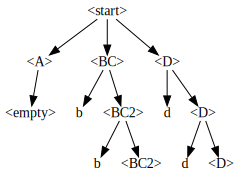

In [7]:
def as_tree(grammar):
    f = GrammarFuzzer(grammar)
    
    derivation_tree = f.init_tree()
    for i in range(6):
        derivation_tree = f.expand_tree_once(derivation_tree)    
    display_tree(derivation_tree)

as_tree(example_grammar)

And we can use it to produce valid input values

In [8]:
def test_input(grammar):
    f = GrammarFuzzer(grammar)
    input_value =  f.fuzz()
    print('%s matches %s: %s' % (input_value, pattern, regex.match(pattern, input_value) != None))

for i in range(5):    
    test_input(example_grammar)

ccbbcbbb matches a?(b|c)+d*$: True
abbbbd matches a?(b|c)+d*$: True
c matches a?(b|c)+d*$: True
bbc matches a?(b|c)+d*$: True
bbcbbccbcbcc matches a?(b|c)+d*$: True


## Objective

The goal of this project is to _implement an algorithm that constructs a CFG from an arbitrary regular expression. Then, use the techniques learned in the lecture (i.e. efficient grammar-based fuzzing) to automatically expand your grammar and to automatically produce a set of inputs that match the given regular expression, covering as many grammar productions as possible._

## Regex specification

In this project, we restrict the regex specification into its simpler constructions and grouped then into 3 categories: _basic syntax, complex syntax and bonus_ as follows:

| Category | Components |
|----------|-----------|
| Basic Syntax | Anchors `^` and `$` <br> Groupings `()` <br> Whitespace `\s =  [ \t\n\r\f\v]` <br> Quantifiers `*`, `+`, `?` <br> concatenation <br> OR operator <code>&#124;</code> | 
| Complex syntax | Character classes `[0-9]`, `[a-z]`, `[A-Z]`, `[0-9A-Za-z]`  <br> Special character classes `\d = [0-9]`, `\w = [0-9a-zA-Z_]` <br> Bounded quantifier `{}` <br> Set Negation `[^]` (requires look-ahead) <br> `\D = [^0-9]` <br> `\W = [^0-9a-zA-Z_]` <br> `\S = [^\s]` | 
| Bonus | Boundaries `\b` and `\B`  |   |

In your implementation, ignore any non-listed regex elements, such as flags, back references, other types of look-ahead, look-behind and greedy/lazy match. 

We use the [regex parser](https://pypi.org/project/regex/), version 2.4.151, instead of Python's native `re`, because `re` is just a wrapper for a C library. Confirm regex version using: 

In [10]:
print(regex.__version__)

2.4.151


## Regex samples for development

Ensure your implementation works on the following regex examples, and covers the provided minimum required coverage for parsing a represententative input for each regex:

| Category | Examples | Min. Cov. LOC _regex_core.py | Min. Cov. LOC *.c|
|--------------|----------|------|------|
| Basic Syntax | `^ab$` | 241 (8%)  |  988     (7%)| 
| Basic Syntax | `b$` | 170 (6%) | 949     (6%) |
| Basic Syntax | `ab*$` | 207 (7%) | 1142     (8%) |
| Basic Syntax | <code>a&#124;b`$`</code> | 308 (11%) | 1024     (7%) |
| Basic Syntax | <code>a(b&#124;c)`$`</code> | 321 (11%)  | 1198     (8%)|
| Basic Syntax | <code>(a&#124;b)\s`$`</code> | 334 (12%) |  1131     (8%) |
| Basic Syntax | <code>^a*(b+&#124;c)d?`$`</code> | 413 (15%) | 1442    (10%) |
| Basic Syntax | <code>^a*(b+&#124;c)d?\se`$`</code> | 455 (16%)  | 1632    (11%) |
| Basic Syntax | <code>^a+(b*&#124;c)d?\se`$`</code> | 426     (15%) | 1564    (11%) |
|  Complex Syntax | `^[0-9]+\s[a-z]*\s?[A-Z]+$`</code> | 303     (11%) | 1228     (9%) |
| Complex Syntax | `\w$` | 169 (6%)  |  878 (6%) |  
| Complex Syntax | `\d$` | 169 (6%) | 875 (6%) | 
| Complex Syntax | <code>(a&#124;b){2,5}$</code> | 401 (14%) |  1380    (10%)| 
| Complex Syntax | `[0-9a-zA-Z]$` | 252 (9%) | 902     (6%) |
| Complex Syntax | `[0-9]$` | 222 (8%) | 852     (6%) |
| Complex Syntax | `[a-z]$` | 222 (8%) | 852     (6%) |
| Complex Syntax | `[^a-zA-Z]$` | 213 (7%)| 879     (6%) |
| Complex Syntax | `[^0-9]$` | 178 (6%) | 825     (6%) | 
| Complex Syntax | `\D$` | 168 (6%) |  877     (6%) |
| Complex Syntax | `\W$` | 122 (4%) |  852     (6%) |
| Complex Syntax | `\S$` | 122 (4%) |  852     (6%) |
| Complex Syntax | `[a-zA-Z]\s\w+\s\d\s$` | 324     (11%) | 1295     (9%) |
| Complex Syntax |  `a(bc){2,5}$` | 297     (10%) | 1472 (10%) |
| Bonus | `\babc\b$` | 258 (9%) | 865     (6%) |
| Bonus | `abc\B` | 177 (6%) | 987     (7%) |
| Bonus | `\babc\B` | 247 (9%) | 928     (6%) |
    

Note that the code coverage during the execution of the import statement (`import regex`) is unacccounted for, since this module was executed before the collection of coverage data began. We also do not track or evaluate the coverage of the python code (`regex.py`), since it is always the same for`regex.match` method call.

Coverage data for Python (i.e. `_regex_core.py`) were obtained using a python utility for measuring code coverage of Python programs called [Coverage.py](https://coverage.readthedocs.io/en/v4.5.x/), version 4.5.2. Confirm your Coverage.py version:

In [11]:
!coverage --version

Coverage.py, version 4.5.2 with C extension
Documentation at https://coverage.readthedocs.io


Coverage data for the C extensions of regex (i.e. _regex.c  and _regex_unicode.c) were obtained using the python utility for GNU gcov utility [Gcovr](https://gcovr.com/), version 4.1. You can confirm your Gcovr version using:

In [12]:
!gcovr --version

gcovr 4.1

Copyright 2013-2018 the gcovr authors
Copyright 2013 Sandia Corporation
Under the terms of Contract DE-AC04-94AL85000 with Sandia Corporation,
the U.S. Government retains certain rights in this software.


## Tips
For more information on Python regex matching read the documentation of Python3 [re](https://docs.python.org/3/library/re.html).

To test your implementation with sample regex inputs, use the following python libraries that generate matching strings for any regex: [rstr](https://bitbucket.org/leapfrogdevelopment/rstr) & [exrex](https://github.com/asciimoo/exrex).

# Evaluation

Your generated test inputs will be executed on [the fuzzingbook server](https://fuzzingbook.cispa.saarland/), based on the amount of executed methods and lines of code (LOC). 

__Note: if you are developing locally, use the source code of version 2018.11.07 of the [regex parser](https://pypi.org/project/regex/), however test on [the fuzzingbook server](https://fuzzingbook.cispa.saarland/) before submission.__
    
Your implementation will be tested with a _secret_ set of regex, encompassing all previously specified syntax categories.

## Grading framework

For grading:
  * __To pass__, your implementation should automatically construct a grammar for an arbitrary set of regular expressions encompassing the basic syntax in the Regex Specification. __Points__ will be assigned based on the coverage achieved by the generated test inputs.
  * __To obtain extra points__, your implementation should support the construction of the grammar for all or some of the complex syntax specification. __Points__ will be assigned based on the number of features you cover, as well as on the coverage achieved by your generated test inputs.
  * __Bonus Points__ will be awarded to implementation which support the bonus specification (boundaries).


## Auxiliary functions

The following functions are available to assist your implementation and tests:

### Generating Sample inputs from your grammar

Using the GrammarCoverageFuzzer, produce unique set of inputs from your grammar:

In [ ]:
from GrammarCoverageFuzzer import GrammarCoverageFuzzer
from Grammars import is_valid_grammar, def_used_nonterminals
import random

def generate_inputs(grammar):
    assert is_valid_grammar(grammar)
    start_seed, end_seed = 2000, 2005
    inputs = []
    for seed in range(start_seed, end_seed):
        random.seed(seed)
        f = GrammarCoverageFuzzer(grammar)
        while (len(f.max_expansion_coverage() - f.expansion_coverage()) > 0):
            inputs.append(f.fuzz()) 
    return set(inputs)


### Ensuring all inputs are valid

Your grammar should produce __only__ valid inputs. To ensure that all inputs your grammar can produce are valid you can use:

In [ ]:
def ensure_all_valid(pattern, inputs):
    res = [[inp, regex.match(pattern, inp) != None] for inp in inputs]
    
    failures = list(filter(lambda x: not x[1], res))
    
    if len(failures) > 0:
        raise ValueError("Invalid inputs: " + str([x[0] for x in failures]))

### Python: Obtaining code coverage for an input

You can use the `run_with_py_coverage` function to obtain the python code covered by each input generated by your grammar.

In [ ]:
from coverage import Coverage
import os

In [ ]:
def run_with_py_coverage(pattern, inp):
    cwd = os.getcwd()
    target_dir = os.path.join(cwd,"data", "regex")
    os.chdir(target_dir)
    
    regex._cache = {}
    cov = Coverage(include=["*.py"])
    cov.start()
    regex.match(pattern, str(inp))
    cov.stop()
    cov.save()
    results = cov.analysis2("regex_3/_regex_core.py")
    covered = set(results[1]) - set(results[3])

    os.chdir(cwd)
    return covered, len(set(results[1]))

### C Extensions: Obtaining code coverage for an input
We implement helper function to execute bash commands:

In [ ]:
import subprocess

def execute_bash_command(command):
    process = subprocess.Popen(command, shell=True,
                       stdout=subprocess.PIPE, 
                       stderr=subprocess.PIPE)
    out, error = process.communicate()
    error = error.decode("utf-8").strip() 
    if error:
        raise ValueError("bash command error: '{0}',\n during execution of command: \n '{1}': ".format(error, command ))
    res = out.decode("utf-8").strip()
    return res


We implement the function `run_with_c_coverage()` to obtain coverage for the C classes in the regex module. 


In [ ]:
import os

def run_with_c_coverage(pattern, inp):
    cwd = os.getcwd()
    target_dir = os.path.join(cwd , "data", "regex")
    if os.getcwd() != target_dir and os.path.isdir(target_dir):
        os.chdir(target_dir)        
    
    #remove old build
    build_dir = os.path.join(os.getcwd(), "build")
    if os.path.isdir(build_dir):
        rm_command = "rm -r " + build_dir 
        execute_bash_command(rm_command)
        
    #re-build regex 
    c_flags = 'CFLAGS="-fprofile-arcs -ftest-coverage -fPIC -g -O0" ' 
    build_instr = 'python setup.py build_ext --inplace > /dev/null'
    build_command = c_flags + build_instr
    execute_bash_command(build_command)

    #run regex match test
    run_test_command = """python -c "from regex_3 import _regex_core;\
                        from regex_3 import regex;pattern = '{0}'; inp = '{1}';\
                        regex._cache = {{}}; regex.match(pattern, str(inp))" """.\
                        format(pattern, inp.replace("\n", "\\\n").replace("\r", "\\\r"))

    execute_bash_command(run_test_command) 

    #obtain coverage of c extensions
    gcovr_instr = 'gcovr -r . '
    grep_TOTAL =  'grep -n "TOTAL" '
    c_cov_command = gcovr_instr + "| " + grep_TOTAL 
    cov_out = execute_bash_command(c_cov_command) 
    coverage = cov_out.split()[2]
    percent_coverage = cov_out.split()[3]

    os.chdir(cwd)
    return coverage, percent_coverage

### Obtain both Python and C coverage for a population of inputs 
For all your inputs, use `population_coverage` to obtain the overall cummulative coverage of Python code and the maximum coverage for C Code.

In [ ]:
def population_coverage(pattern, population):
    py_all_coverage = set()
    c_max_coverage = 0
    c_max_percent = 0
    py_max_percent = ""

    for inp in population:
        #obtain all covered LOC for Python code
        py_covered, py_length = run_with_py_coverage(pattern, inp)
        py_all_coverage |= py_covered

        #obtain max coverage for C code
        c_covered, percent_covered = run_with_c_coverage(pattern, inp)
        if c_max_coverage < int(c_covered):
            c_max_coverage = int(c_covered)
            c_max_percent = percent_covered
    
    py_max_percent = str(int(len(py_all_coverage)/py_length * 100)) + "%"
        
    return len(py_all_coverage), c_max_coverage, py_max_percent, c_max_percent

## Your code
Write your code here to create a grammar out of an arbitrary regular expression. 

In [ ]:
import string
from collections import defaultdict

grammar = defaultdict(list)

#write your code below

#regex to context free grammar conversion
def regex_to_CFG(regex_pattern):
    
    return grammar
    


## Evaluation code

The following code will be used to run your evaluation.

__Note that the set of regular expression which will be used for evaluation may be different from those provided as example.__

In [ ]:
secret_set_of_regex = [[r'^ab$', 241, 988], [r'b$', 170, 949],[r'ab*$', 207, 1142],\
                       [r'a|b$',308, 1024], [r'a(b|c)$', 321, 1198], [r'(a|b)\s$',334, 1131],\
                       [r'^a*(b+|c)d?$', 413, 1442],[r'^a*(b+|c)d?\se$', 455, 1632],\
                       [r'^a+(b*|c)d?\se$',426, 1564], [r'^[0-9]+\s[a-z]*\s?[A-Z]+$', 303, 1228],\
                       [r'\w$', 169, 878], [r'\d$', 169, 875], [r'(a|b){2,5}$', 401, 1380],\
                       [r'[0-9a-zA-Z]$', 252, 902], [r'[0-9]$', 222, 852], [r'[a-z]$', 222, 852],\
                       [r'[^a-zA-Z]', 213, 879], [r'[^0-9]', 178, 825],\
                       [r'\D$', 168, 877], [r'\W', 122, 852] , [r'\S', 122, 852],\
                       [r'[a-zA-Z]\s\w+\s\d\s$', 324, 1295], [r'a(bc){2,5}$', 297, 1472],\
                       [r'\babc\b$', 258, 865], [r'abc\B', 177, 987], [r'\babc\B', 247, 928]]

In [ ]:
to_process = []
for pattern, py_min_coverage, c_min_coverage in secret_set_of_regex:
    grammar = regex_to_CFG(pattern)
    to_process.append([pattern, py_min_coverage, c_min_coverage, grammar])

Each regex will be evaluated individually, against a minimum precomputed coverage.
Plot coverage result and indicate errors.   

In [ ]:
def evaluate(grammar, pattern, py_min_coverage, c_min_coverage):
    
    inputs = generate_inputs(grammar)
    ensure_all_valid(pattern, inputs)
    
    py_all_coverage, c_max_coverage,  py_percent, c_percent = population_coverage(pattern, inputs)    
    
    return py_all_coverage >= py_min_coverage and c_max_coverage >= c_min_coverage, py_all_coverage, c_max_coverage, py_percent, c_percent

Plot coverage result and indicate errors.   

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_bar_chart(py_cov_tuple, c_cov_tuple,  py_err, c_err, num_grammars):
    
    fig, ax = plt.subplots(figsize=(20,10))
    index = np.arange(num_grammars)
    bar_width = 0.4
    opacity = 0.4
    error_config = {'ecolor': '0.3'}

    rects1 = ax.bar(index, py_cov_tuple, bar_width,
                    alpha=opacity, color='b', yerr=py_err,
                    error_kw=error_config,
                    label='Python Code')

    rects2 = ax.bar(index + bar_width, c_cov_tuple, bar_width,
                    alpha=opacity, color='r', yerr=c_err,
                    error_kw=error_config,
                    label='C Code')

    ax.set_xlabel('Regex')
    ax.set_ylabel('Coverage (LOC)')
    ax.set_title('Coverage of Regex by Language (Python & C)')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(('1', '2', '3', '4', '5', '6', '7', '8', '9', '10',\
                       '11', '12', '13', '14', '15', '16', '17', '18', '19', '20',\
                       '21', '22', '23', '24', '25', '26'))
    ax.legend()

    fig.tight_layout()
    plt.show()

Final result will be computed accordingly:

In [ ]:
def compute_results():
    overall_result, py_cov_list, c_cov_list, py_err, c_err, evaluation_list, failed_regexes = [], [], [], [], [], [], []
    
    dash = '-' * 98
    print(dash)
    print('{:<28s}{:>12s}{:>12s}{:>12s}{:>12s}{:>18s}'.format("Pattern", "Py_cov (LOC)", "Py_cov (%)", "C_cov (LOC)", "C_cov (%)", "Pass(1)/Fail(0)"))
    print(dash)

    
    for pattern, py_min_coverage, c_min_coverage, grammar in to_process:    
        evaluation_result, py_all_coverage, c_max_coverage, py_percent, c_percent = evaluate(grammar, pattern, py_min_coverage, c_min_coverage)

        py_cov_list.append(py_all_coverage)
        c_cov_list.append(c_max_coverage)
        evaluation_list.append(evaluation_result)
        if py_all_coverage < py_min_coverage:
            py_err.append((py_all_coverage - py_min_coverage ))
            failed_regexes.append([pattern, "Py"])
        else:
            py_err.append(0)
        if c_max_coverage < c_min_coverage:
            c_err.append((c_max_coverage - c_min_coverage ))
            failed_regexes.append([pattern, "C"])
        else:
            c_err.append(0)

        print('{:<28s}{:>12d}{:>12s}{:>12d}{:>12s}{:>12b}'.format(pattern, py_all_coverage, py_percent, c_max_coverage, c_percent, c_max_coverage >= c_min_coverage and  py_all_coverage >= py_min_coverage))

        overall_result.append([pattern, evaluation_result])

    plot_bar_chart(tuple(py_cov_list), tuple(c_cov_list), tuple(py_err), tuple(c_err), len(to_process))
    score = sum(evaluation_list)
    print("Score: {0}/{1}\nScore Percentage: {2}%".format(score,len(evaluation_list), ((score*100)/len(evaluation_list))))
    if failed_regexes:
        print("The following regexes failed the coverage baseline: ", failed_regexes)


In [ ]:
compute_results()